## Ensemble Model

In this notebook, we add new features to the dataset. Data subsets are formed and preprocessing will be applied on each subset. The labels will be created and the models will be built and tested.

In [1]:
import glob, os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random, math, datetime, operator, pickle
from collections import defaultdict, Counter
from pandas_summary import DataFrameSummary
from tqdm import tqdm

from pyti import aroon, bollinger_bands, chaikin_money_flow, commodity_channel_index
from pyti import moving_average_convergence_divergence, momentum, volatility, moving_average_envelope as ma

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from brew.base import Ensemble, EnsembleClassifier
from brew.combination.combiner import Combiner 

% matplotlib inline

First, we import data from our previous step which includes the `close` price of all tickers in the sector.

In [2]:
df1 = pd.read_csv('../Data/sector_joined_closes_train.csv', index_col='Date_Time')
display(DataFrameSummary(df1).summary())

,APA,APC,CHK,CNX,COG,COP,CVX,DNR,DO,DVN,...,NBR,NE,NFX,NOV,OXY,RDC,RRC,SLB,SWN,XOM
count,10768,10768,10768,10768,10768,10768,10768,10768,10768,10768,...,10768,10768,10768,10768,10768,10768,10768,10768,10768,10768
mean,47.437,45.7934,4.84221,14.7981,23.7087,44.4693,105.003,1.48958,11.0506,31.3609,...,8.00725,3.77339,28.3484,32.8013,59.9768,11.1654,22.488,66.8505,5.92941,81.4117
std,1.13833,1.74617,0.186551,0.580913,1.12629,1.05357,1.46266,0.0773415,0.507319,1.02835,...,0.438946,0.184845,1.38747,0.721589,0.850064,0.841013,0.713273,1.48715,0.207706,0.847052
min,44.6,42.59,4.38,13.56,21.57,42.51,102.56,1.27,10.06,28.81,...,6.94,3.34,25.48,31.39,57.85,9.75,20.95,64.19,5.46,79.81
25%,46.65,44.32,4.71,14.39,22.76,43.5,104.07,1.43,10.69,30.61,...,7.7,3.65,27.35,32.23,59.41,10.52,21.95,65.7,5.79,80.83
50%,47.56,45.52,4.83,14.86,23.58,44.28,104.56,1.51,10.99,31.34,...,8.02,3.79,28.16,32.74,59.94,10.83,22.38,66.125,5.94,81.25
75%,48.17,46.93,5,15.23,24.8,45.34,106.13,1.55,11.45,31.99,...,8.29,3.9,29.3,33.23,60.57,12.02,23.13,68.21,6.09,81.9
max,50.18,50.42,5.29,16.13,25.5,46.7,108.48,1.68,12.31,33.89,...,9.05,4.28,31.11,34.77,62.09,13.1,23.95,70.65,6.47,83.63
counts,10768,10768,10768,10768,10768,10768,10768,10768,10768,10768,...,10768,10768,10768,10768,10768,10768,10768,10768,10768,10768
uniques,544,754,90,258,383,415,576,41,223,498,...,212,94,563,336,416,336,300,613,100,377


In [3]:
df1_cols = df1.columns.tolist()
print (df1_cols)

['APA', 'APC', 'CHK', 'CNX', 'COG', 'COP', 'CVX', 'DNR', 'DO', 'DVN', 'EOG', 'FTI', 'HAL', 'HES', 'HP', 'KMI', 'MPC', 'MRO', 'NBL', 'NBR', 'NE', 'NFX', 'NOV', 'OXY', 'RDC', 'RRC', 'SLB', 'SWN', 'XOM']


For the rest of this project, we assume `APC` is the stock that we are interested to predict. It is ideal to have classifiers built on the entire sector in the pool, but to save time in this project, we just add classifers from 2 highly correlated stocks with `APC` meaning `NFX` and `SLB` to the pool (from heatmap analysis in Exploratory Analysis). So, we repeat processes up to Build Ensemble for all 3 stocks. 

In [4]:
ticker = 'APC'
# ticker = 'NFX'
# ticker = 'SLB'

### Feature Engineering

In this section, we create some new features using `technical indicators` which is calculated based on `ohlcv` data of a given stock. These indicators have been used by traders for a long time, and we use a few of them that we think are more informative as follows:

- Aroon indicator
- Bollinger bands 
- Chaikin volatility 
- Chaikin money flow
- Moving average convergence divergence (MACD)
- Commodity channel index 
- Momentum
- Volatility

> **Note:** we should be careful with leaking data from training to validation set. So, these new features should be created on a subset basis. 

In [5]:
# read ohlcv data for a given ticker needed for calculation of technical indicators
def read_ticker(ticker, path):
    '''
    this function reads ohlcv data for a given ticker
    '''
    colnames = ['Ticker', 'Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = pd.read_csv(path + '/{}.csv'.format(ticker), parse_dates=[['Date','Time']], names=colnames)
    data = data.set_index('Date_Time')
    data.drop('Ticker', 1, inplace=True)
    return data

# Let's test our function
path1 = '../Data/nyse_20170606_20170617_1minute'
df2 = read_ticker(ticker, path1)

I have used a library called [pyti](https://github.com/kylejusticemagnuson/pyti) to calculate these features. I just need to write a function that can be used later to generate technical indicators as new set of features. For simplicity, I use the same time window size for all these indicators. This is something that has potential to be optimized.

In [6]:
def technical_indicators(df, w):
    '''
    this function gets ohlcv data from dataframe df
    and adds new columns based on some technical 
    indicators calculated on sliding time window of tw.
    tw : time window
    '''
    np.seterr(divide='ignore', invalid='ignore')
    df['aroon_up'] = aroon.aroon_up(df['Close'].values,w)
    df['aroon_down'] = aroon.aroon_down(df['Close'].values,w)
    df['upper_bb'] = bollinger_bands.upper_bollinger_band(df['Close'].values,w)
    df['middle_bb'] = bollinger_bands.middle_bollinger_band(df['Close'].values,w)
    df['lower_bb'] = bollinger_bands.lower_bollinger_band(df['Close'].values,w)
    df['chaikin_money_flow'] = chaikin_money_flow.chaikin_money_flow(df['Close'].values, 
                                                                     df['High'].values,
                                                                     df['Low'].values,
                                                                     df['Volume'].values,w)
    df['macd'] = moving_average_convergence_divergence.moving_average_convergence_divergence(df['Close'].values, 
                                                                                             w, 2*w)
    df['cci'] = commodity_channel_index.commodity_channel_index(df['Close'].values, 
                                                                 df['High'].values,
                                                                 df['Low'].values, w)
    df['momentum'] = momentum.momentum(df['Close'].values, w)
    df['volatility'] = volatility.volatility(df['Close'].values, w)
    df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)
    return df

In [7]:
# just to check the function
df_check = df2.copy()
new_features = technical_indicators(df_check, 6)
new_columns = new_features.columns.tolist()
new_columns

['aroon_up',
 'aroon_down',
 'upper_bb',
 'middle_bb',
 'lower_bb',
 'chaikin_money_flow',
 'macd',
 'cci',
 'momentum',
 'volatility']

Let's check the range of these indicators.

In [8]:
new_features.replace([np.inf, -np.inf], np.nan)
new_features.dropna(inplace=True)
new_features.max(axis=0)
for i in range(len(new_columns)):
    print('%.2f  ' %round(new_features[new_columns[i]].min(axis=0),2), 
          '%.2f  ' %round(new_features[new_columns[i]].max(axis=0),2))

16.67   100.00  
16.67   100.00  
42.85   50.44  
42.70   50.39  
42.51   50.35  
-1.00   1.00  
-0.22   0.24  
-32.86   22.24  
-0.84   0.91  
2.26   244.95  


As can be seen above, it makes sense to transforms these features by scaling them to [-1,1] range after splitting to train and test subsets.

Now, we merge df1 and df2 before creating subsets. This makes next steps easier. For this task, we use `left` join and not `inner` join. It is because assuming all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it.

In [9]:
def join_df(dat1, dat2):
    return dat1.join(dat2, how='left')

In [10]:
joined = join_df(df1, df2)
len(joined[joined.Close.isnull()])

20

In [11]:
joined.dropna(inplace=True)
len(joined[joined.Close.isnull()])

0

In [12]:
joined.head()

,APA,APC,CHK,CNX,COG,COP,CVX,DNR,DO,DVN,...,RDC,RRC,SLB,SWN,XOM,Open,High,Low,Close,Volume
Date_Time,,,,,,,,,,,,,,,,,,,,,
2017-06-06 13:31:00,46.65,49.61,4.92,14.15,21.74,43.99,103.23,1.44,11.60,33.11,...,12.02,22.04,68.91,5.78,80.25,49.56,49.61,49.56,49.61,34514.0
2017-06-06 13:32:00,46.66,49.55,4.90,14.15,21.69,43.96,103.14,1.44,11.62,33.08,...,12.06,21.94,68.88,5.77,80.24,49.60,49.63,49.53,49.55,7441.0
2017-06-06 13:33:00,46.73,49.61,4.92,14.10,21.89,44.04,103.15,1.45,11.62,33.15,...,12.12,22.05,68.88,5.81,80.36,49.56,49.62,49.56,49.61,3900.0
2017-06-06 13:34:00,46.79,49.56,4.91,14.13,21.81,43.94,103.09,1.46,11.59,33.10,...,12.06,22.04,68.84,5.78,80.29,49.60,49.60,49.56,49.56,2240.0
2017-06-06 13:35:00,46.76,49.57,4.91,14.11,21.86,43.93,102.92,1.44,11.52,32.99,...,12.01,22.04,68.76,5.81,80.26,49.57,49.57,49.50,49.57,7087.0


### Create Subsets

As explained before, we are going to create random subsets of historical data. For each random subset, we split data to train and validation sets, we create new features and labels, and finally we resample to make dataset balanced.

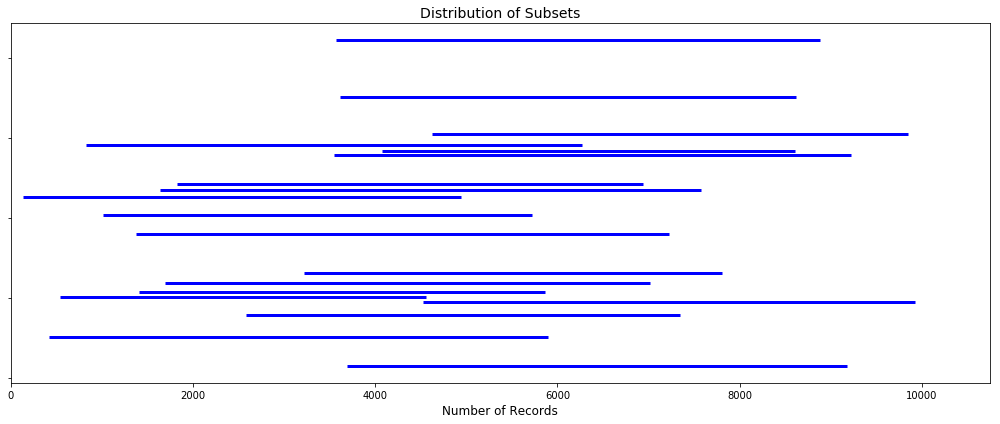

In [13]:
def create_subs(df, nsub, min_span, max_span):
    '''
    this function generates data subsets from random starting and ending periods
    nsub : total number of periods
    min_span : minimum period length
    max_span : maximum period length
    
    '''
    subs = {}
    S, L = [], [] # keeps track of start and length for each subset
    random.seed(131)  
    for i in range(nsub):
        start, length = random.randint(0, len(df)-max_span), random.randint(min_span, max_span)
        subs[i] = df.iloc[start:start+length]
        S.append(start)
        L.append(length)    
    return subs, S, L

# create data subsets 
n_subs = 20
subs, lineoffsets, linelengths = create_subs(joined, n_subs, 4000, 6000)
lineoffsets_shifted = list(map(lambda x,y: x+y/2, lineoffsets, linelengths))

np.random.seed(122)
positions = np.random.random([n_subs, 1])*1000


fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(111)
ax1.eventplot(positions, 
              lineoffsets=lineoffsets_shifted,
              linelengths=linelengths, 
              orientation='vertical',
              colors = 'b',linewidths=3)
ax1.set_title('Distribution of Subsets', fontsize=14)
# ax1.set_ylim([0,5])
ax1.set_yticklabels([])
ax1.set_xlim([0,len(joined)])
ax1.set_xlabel('Number of Records', fontsize=12)
plt.tight_layout()
plt.savefig('../Figs/subsets.pdf', dpi=300)

In [14]:
subs[0].head()

,APA,APC,CHK,CNX,COG,COP,CVX,DNR,DO,DVN,...,RDC,RRC,SLB,SWN,XOM,Open,High,Low,Close,Volume
Date_Time,,,,,,,,,,,,,,,,,,,,,
2017-06-14 17:32:00,47.73,47.26,5.01,14.95,22.91,45.26,106.29,1.46,11.43,31.87,...,12.27,22.98,67.75,6.12,81.83,47.26,47.27,47.24,47.26,8721.0
2017-06-14 17:33:00,47.71,47.24,5.00,14.95,22.88,45.25,106.25,1.45,11.44,31.88,...,12.29,22.96,67.74,6.12,81.79,47.26,47.26,47.24,47.24,5625.0
2017-06-14 17:34:00,47.72,47.23,5.01,14.96,22.88,45.23,106.26,1.44,11.45,31.87,...,12.29,22.95,67.78,6.12,81.77,47.24,47.26,47.21,47.23,10421.0
2017-06-14 17:35:00,47.74,47.24,5.00,14.96,22.90,45.24,106.30,1.44,11.44,31.88,...,12.30,22.98,67.80,6.11,81.79,47.22,47.24,47.21,47.24,10039.0
2017-06-14 17:36:00,47.78,47.22,5.00,14.95,22.89,45.23,106.28,1.45,11.45,31.88,...,12.31,22.95,67.78,6.11,81.81,47.24,47.25,47.20,47.22,30455.0


In [15]:
len(subs[0])

4762

Now, we need a function to split each subset to train and validation subsets. We will use validation subset to find top k classifiers that work best for each subset.

In [16]:
def train_val_split(dfs):
    '''
    this function gets a dictioary of subsets in dataframe format
    and returns train and validation dictionaries.
    '''
    train, valid = {}, {}
    for k,v in dfs.items():
        
        split_ix = int(0.9*len(v))
        temp1 = v.iloc[:split_ix,:].copy()
        temp2 = v.iloc[split_ix:,:].copy()
        
        train[k] = technical_indicators(temp1,6)
        train[k].replace([np.inf, -np.inf], np.nan)
        train[k].dropna(inplace=True)
        
        valid[k] = technical_indicators(temp2,6)
        valid[k].replace([np.inf, -np.inf], np.nan)
        valid[k].dropna(inplace=True)
        
    return train, valid     

trains, valids = train_val_split(subs)

As shown earlier, it doesn't hurt to scale technical indicators for each train and validation subset. I don't scale other features (closing price of the correlatd stocks) as they will be used to create labels. Later on, these features will be transformed using `pct.change()` function.

In [16]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def scale_tech_indicators(trs, vals):
    '''
    this function scales technical features in the created 
    feature space for the train and validation sets of each subset
    '''
    sclrs, trs_sc, vals_sc = {}, {}, {}
    for (k1,v1), (k2,v2) in zip(trs.items(),vals.items()):
        temp1, temp2 = v1[df1_cols], v2[df1_cols]
        ix1, ix2 = temp1.index, temp2.index
        sclrs[k1], temp3, temp4  = scale(v1[new_columns].values,v2[new_columns].values)
        temp3 = pd.DataFrame(temp3.astype(float), columns=new_columns, index=ix1)
        temp4 = pd.DataFrame(temp4.astype(float), columns=new_columns, index=ix2)
        trs_sc[k1] = join_df(temp1, temp3)
        vals_sc[k1] = join_df(temp2, temp4)
    return sclrs, trs_sc, vals_sc

In [18]:
scalers, trains_scaled, valids_scaled = scale_tech_indicators(trains, valids)

In [19]:
trains_scaled[0].head(n=2)

,APA,APC,CHK,CNX,COG,COP,CVX,DNR,DO,DVN,...,aroon_up,aroon_down,upper_bb,middle_bb,lower_bb,chaikin_money_flow,macd,cci,momentum,volatility
Date_Time,,,,,,,,,,,,,,,,,,,,,
2017-06-14 17:43:00,47.87,47.23,5.00,14.96,22.89,45.25,106.33,1.45,11.40,31.90,...,1.0,0.2,0.832879,0.850411,0.857659,0.270543,0.140362,0.457552,0.255172,-0.737095
2017-06-14 17:44:00,47.86,47.20,5.01,14.96,22.89,45.24,106.37,1.45,11.43,31.92,...,0.6,-0.2,0.833132,0.853869,0.864035,0.293597,0.159383,0.432194,0.158621,-0.700278


In [20]:
# import pickle 
# f = open('clean_train_data.pickle', 'wb')
# pickle.dump(trains_scaled, f)
# pickle.dump(valids_scaled, f)
# f.close()

In [17]:
f = open('clean_train_data.pickle', "rb")
trains = pickle.load(f)
valids = pickle.load(f)
f.close()

### Create Labels

In [18]:
def spread(label):
    '''
    this function summarizes the distribution of labels in each class.
    '''
    spread = [str(i) for i in label]
    return Counter(spread)
    
def process_data_for_labels(df, ticker, future=1, dropnan=False):   
    for i in range(1,future+1):
        df['{}_{}m'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]   
    if dropnan:
        df.dropna(inplace=True)
    return df.iloc[future-1:]

def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.00025
    for col in cols:
        if col > requirement:
            return 2
        if col < -requirement:
            return 0
    return 1

In [19]:
def extract_featuresets(df, ticker):
    dfc = df.copy()
    dfc = process_data_for_labels(dfc, ticker)
    tickers = df1_cols
    dfc['{}_target'.format(ticker)] = list(map( buy_sell_hold, dfc['{}_1m'.format(ticker)]))

    vals = dfc['{}_target'.format(ticker)].values.tolist()
    spread(vals)

    dfc.fillna(0, inplace=True)
    dfc.replace([np.inf, -np.inf], np.nan)
    dfc.dropna(inplace=True)

    dfc_vals = dfc[[tk for tk in tickers]].pct_change()
    dfc_vals = dfc_vals.replace([np.inf, -np.inf], 0)
    dfc_vals.fillna(0, inplace=True)
    dfj = join_df(dfc_vals, dfc[new_columns])
    X = dfj.values
    y = dfc['{}_target'.format(ticker)].values
    
    return X, y, dfj

In [20]:
# let's test our function
X, y, d = extract_featuresets(trains[5], ticker)

In [21]:
spread(y)

Counter({'1': 1690, '0': 1517, '2': 1384})

In [22]:
X.shape

(4591, 39)

In [23]:
y[:10]

array([1, 1, 0, 1, 2, 1, 1, 0, 0, 0])

### Sampling
I have printed distribution of labels for each class in a random subset. As can be seen, the subset is not balanced, which is pretty common in timeseries data analysis. There are 2 general approches to deal with this issue. One is undersampling which is not ideal for our case with limited number of samples. The other approach is [oversampling](https://beckernick.github.io/oversampling-modeling/). We will use and implement this technique and more specifically `SMOTE` algorithm on train and validation datasets to avoid information leakage. 

### Build Model

In [24]:
def model(ticker, train, validation, prefix, k):
    '''
    this function gets the ticker name that prediction should be conducted on
    as well as the train and validation subsets. Other variables are:
    
    'prefix' : an integer to initialize the folder name for each subset
    'k' : an integer representing number of requested top classifiers 
    
    It creates labels and makes the train sample balanced using oversampling. 
    Finally, it fits a list of models to the train subset, and stores the top 
    k classifiers in the pool folder.
    '''
    X_tr, y_tr, d1 = extract_featuresets(train, ticker)
    X_val, y_val, d2 = extract_featuresets(validation, ticker)
    sm = SMOTE(random_state=12)
    X_tr_res, y_tr_res = sm.fit_sample(X_tr, y_tr)
    
    clfs = []
    for clf,clfname in (
       [KNeighborsClassifier(n_neighbors=3),'knn3'],
       [KNeighborsClassifier(n_neighbors=6),'knn6'],
       [ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'), 'et10'],
       [ExtraTreesClassifier(n_estimators=20, n_jobs=-1, criterion='entropy'), 'et20'],
       [ExtraTreesClassifier(n_estimators=50, n_jobs=-1, criterion='entropy'), 'et50' ],
       [ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'), 'et100' ],
       [GradientBoostingClassifier(n_estimators=10), 'gb10'],
       [GradientBoostingClassifier(n_estimators=20),'gb20'],
       [GradientBoostingClassifier(n_estimators=50),'gb50'],
       [GradientBoostingClassifier(n_estimators=100),'gb100'],
       [GradientBoostingClassifier(n_estimators=200),'gb200'],
       [RandomForestClassifier(n_estimators=10, n_jobs=-1),'rf10'],
       [RandomForestClassifier(n_estimators=20, n_jobs=-1),'rf20'],
       [RandomForestClassifier(n_estimators=50, n_jobs=-1),'rf50'],
       [RandomForestClassifier(n_estimators=100, n_jobs=-1),'rf100'],
       [RandomForestClassifier(n_estimators=200, n_jobs=-1),'rf200'],
        ):
        clf.fit(X_tr_res, y_tr_res)
#         score = clf.score(X_val, y_val)
        pred = clf.predict(X_val)
        score = f1_score(y_val, pred, average='weighted')
        clfs.append([clfname, clf, score])

    clfs.sort(key=lambda x: x[2], reverse=True)
    for i in range(k):
        g = open('../Clfs/{}-{}-{}.pickle'.format(ticker,prefix,clfs[i][0]), 'wb')
        pickle.dump(clfs[i][1], g)
        g.close()
        
    return 

In [29]:
# let's test the function
model(ticker, trains[0], valids[0], 1000, 4) 

In [30]:
k = 4 # number of top classifiers that work best on each subset
with tqdm(total=n_subs*k) as pbar:
    for (k1,v1), (k2,v2) in zip(trains.items(),valids.items()):
        model(ticker, v1, v2, k1, k)
        pbar.update(k)
pbar.close()

100%|██████████| 80/80 [06:49<00:00,  5.14s/it]


In [25]:
DIR = '../Clfs'
n_clfs = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])-1
n_clfs

240

In [26]:
os.chdir(DIR)
clfs = []
for file in glob.glob("*.pickle"):
    clfs.append(file)

In [27]:
sorted(clfs)[:5]

['APC-0-et10.pickle',
 'APC-0-et100.pickle',
 'APC-0-knn10.pickle',
 'APC-0-rf50.pickle',
 'APC-1-gb20.pickle']

### Build Ensemble

In [28]:
def prep(df_sector, df_ticker):
    '''
    preprocesses data 
    '''
    df_ticker = technical_indicators(df_ticker, 6)
    df_ticker.replace([np.inf, -np.inf], np.nan)
    df_ticker.dropna(inplace=True)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_ticker_sc = scaler.fit_transform(df_ticker) 
    ix = df_ticker.index
    temp = pd.DataFrame(df_ticker_sc.astype(float), columns=new_columns, index=ix)
    dfj = join_df(df_sector, temp)
    dfj.dropna(inplace=True)
    x, y, d = extract_featuresets(dfj, ticker)
    return x, y, d

def get_data(df, path, s, e):
    '''
    slices data from start to end and preprocesses
    '''
    df_sector = df.iloc[s:e,:]
    df_ticker = read_ticker(ticker, path).iloc[s:e,:]
    x, y, d = prep(df_sector, df_ticker)
    return x, y

def top_k_nondeep_models(X_tr, y_tr, k):
    '''
    finds the top k classifiers from the pool that work best on data in each window
    '''
    pool = []
    for m in clfs:
        f = open('../Clfs/{}'.format(m), "rb")
        clf = pickle.load(f)
        f.close()
        score = clf.score(X_tr, y_tr)
        pool.append([m, score])
    pool_sorted = sorted(pool, key=lambda x: x[1], reverse=True)
    return pool_sorted[:k]

def build_ensemble(top_models, X_tr, y_tr):
    clf_names = [x[0] for x in top_models]
    top_clfs = []
    for clfname in clf_names:
        f = open('../Clfs/{}'.format(clfname), "rb")
        clf = pickle.load(f)
        f.close() 
        top_clfs.append(clf)
        
    ens = Ensemble(classifiers=top_clfs)   
    cmb = Combiner(rule='mean')
    clf_ensemble = EnsembleClassifier(ensemble=ens, combiner=cmb)
    clf_ensemble.fit(X_tr, y_tr)
    return clf_ensemble

### Benchmark

Before evaluating the ensemble model performance, we need to create a benchmark model to compare the results with. At the end of the day, we need to know if our effort to make a better model worth it.

I am going to develop a simple decision tree model on training dataset without using the subsets. Just dividing the train dataset to train and validation and fit the model. Then, I am going to use this fitted model to predict

In [29]:
df_ticker = read_ticker(ticker, path1)
X1, y1, df1_processed = prep(df1, df_ticker)

Let's save X1, y1 to be used by deep model in our another notebook.

In [20]:
# f = open('../Data/deep_data.pickle', "wb")
# pickle.dump(X1, f, protocol=2)
# pickle.dump(y1, f, protocol=2)
# pickle.dump(df1_processed, f, protocol=2)
# f.close()

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.33, random_state=10)
gap = 10 # remove a few elements to avoid leakage
X_train, y_train = X_train[:-gap], y_train[:-gap]
len(X_train), len(X_valid)

(7012, 3459)

In [31]:
print('train class spread', spread(y_train),'\n',
      'test class spread', spread(y_valid))

train class spread Counter({'1': 2630, '0': 2242, '2': 2140}) 
 test class spread Counter({'1': 1341, '0': 1076, '2': 1042})


scikit-learn uses an optimised version of the CART algorithm. CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets.

In [32]:
def benchmark_model(X_tr, y_tr, X_val, y_val):

    grid = ParameterGrid({"criterion": ['gini', 'entropy'],
                          "min_samples_leaf": [3,5,7]})

    clf_dt = DecisionTreeClassifier(random_state=100)
    best_score = -1
    for params in grid:
        clf_dt.set_params(**params)
        clf_dt.fit(X_tr, y_tr)
        pred = clf_dt.predict(X_val)
        score = f1_score(y_val, pred, average='weighted')
#         score = clf_dt.score(X_val, y_val)  
        if score > best_score:
            best_score = score
            best_grid = params
            
    return best_grid, best_score

In [33]:
bg, bs = benchmark_model(X_train, y_train, X_valid, y_valid)
print ('Best Score: %0.5f' % bs )
print ('Grid:', bg)

Best Score: 0.36009
Grid: {'criterion': 'entropy', 'min_samples_leaf': 3}


In [34]:
bm_model = DecisionTreeClassifier(**bg, random_state=101)
bm_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best')

### Test the Model

Now, we test our pool of classifiers along with the benchmark model on the test dataset which has been collected almost one month later after our training/validation dataset.

In [35]:
df_test = pd.read_csv('../Data/sector_joined_closes_test.csv', index_col='Date_Time')
display(DataFrameSummary(df_test).summary())

,APA,APC,CHK,CNX,COG,COP,CVX,DNR,DO,DVN,...,NBR,NE,NFX,NOV,OXY,RDC,RRC,SLB,SWN,XOM
count,1558,1558,1558,1558,1558,1558,1558,1558,1558,1558,...,1558,1558,1558,1558,1558,1558,1558,1558,1558,1558
mean,48.9272,44.1899,4.82786,16.0685,25.0486,43.2065,104.005,1.44402,11.7651,31.9029,...,7.76092,4.04194,26.9239,34.0792,60.3909,11.3157,22.0663,66.8774,5.9827,80.6336
std,0.802632,0.416593,0.0869502,0.339533,0.192764,0.349848,0.463531,0.0412682,0.29899,0.441848,...,0.205053,0.123543,0.581576,0.501027,0.288824,0.272419,0.515382,0.443045,0.137963,0.314009
min,47.35,43.47,4.67,15.53,24.53,42.58,103.18,1.35,11.29,31.11,...,7.45,3.87,25.9,33.35,59.75,10.85,20.9,66,5.72,80
25%,48.37,43.85,4.75,15.74,24.93,42.89,103.65,1.43,11.53,31.48,...,7.58,3.94,26.45,33.62,60.19,11.06,21.65,66.52,5.86,80.4
50%,48.69,44.13,4.83,15.97,25.05,43.23,103.88,1.45,11.69,31.89,...,7.68,3.98,26.74,34.02,60.29,11.29,22.2,66.91,6,80.57
75%,49.73,44.55,4.91,16.3875,25.2,43.52,104.28,1.47,11.92,32.31,...,7.92,4.12,27.45,34.4,60.63,11.45,22.4775,67.23,6.09,80.87
max,50.52,45.53,5.01,16.67,25.6,43.82,105.35,1.56,12.55,32.79,...,8.23,4.35,28.1,35.23,61.21,12.09,22.9,68.57,6.29,81.47
counts,1558,1558,1558,1558,1558,1558,1558,1558,1558,1558,...,1558,1558,1558,1558,1558,1558,1558,1558,1558,1558
uniques,289,175,35,113,106,123,195,22,124,165,...,79,49,209,185,138,118,185,191,57,139


In [36]:
ix = df_test.index[0]
ix

'2017-07-18 09:31:00'

I assume we process data as we receive new sample at every minute.

In [37]:
path2 = '../Data/nyse_20170718_20170721_1minute'
X_test, y_test = get_data(df_test, path2, 0, len(df_test))

In [38]:
#####################
## create and save test data to be used by deep model in our another notebook.
df_ticker2 = read_ticker(ticker, path2)
X1_test, y1_test, df_test_processed = prep(df_test, df_ticker2)

# f = open('../Data/deep_test_data.pickle', "wb")
# pickle.dump(X1_test, f, protocol=2)
# pickle.dump(y1_test, f, protocol=2)
# pickle.dump(df_test_processed, f, protocol=2)
# f.close()
######################

In [30]:
w = 60 # time window
f = 1 # shift in sliding window
start, end = 0, w
m = 5 # update ensemble on the sliding window every m minutes
ct = 0 # counter
actual, pred, prob = [], [], []
benchmark1, benchmark2 = [], []
tot = 1400

with tqdm(total=tot) as pbar:
    while end <= tot-2:
        X = X_test[start:end]
        y = y_test[start:end]
        y_spread = spread(y)
        benchmark1.append(max(y_spread.items(), key=operator.itemgetter(1))[0])
        if ct%m==0:
            top_k = top_k_nondeep_models(X,y,5)
            ct=1
        else:
            ct+=1
        X_sh = X_test[end+f].reshape(1,-1)
        y_sh = y_test[end+f]        
        ens = build_ensemble(top_k, X, y)
        pred_val = ens.predict(X_sh)
        pred_prob = ens.predict_proba(X_sh)
        benchmark2.append(bm_model.predict(X_sh))
        actual.append(y_sh)
        pred.append(pred_val)
        prob.append(pred_prob)
        start, end = start+f, end+f
        pbar.update(1)
pbar.close()  

 96%|█████████▌| 1339/1400 [2:19:19<06:20,  6.24s/it]  


In [31]:
# f = open('../Data/output.pickle', "wb")
# pickle.dump(actual, f)
# pickle.dump(pred, f)
# pickle.dump(prob, f)
# pickle.dump(benchmark1, f)
# pickle.dump(benchmark2, f)
# f.close()

In [39]:
f = open('../Data/output.pickle', "rb")
actual1 = pickle.load(f)
pred1 = pickle.load(f)
prob1 = pickle.load(f)
benchmark11 = pickle.load(f)
benchmark21 = pickle.load(f)
f.close()

In [40]:
print('ensemble model performace is: {}'.format(np.around(f1_score(actual1, pred1, average='weighted'), decimals=5)))
# accuracy_score(actual, pred)

ensemble model performace is: 0.37287


In [41]:
bm1 = list(map(int, benchmark11))
print('benchmark1 score is: {}'.format(np.around(f1_score(actual1, bm1, average='weighted'), decimals=5)))
# accuracy_score(actual, bm1)

benchmark1 score is: 0.37767


In [42]:
bm2 = list(map(int, benchmark21))
print('benchmark2 score is: {}'.format(np.around(f1_score(actual1, bm2, average='weighted'), decimals=5)))
# accuracy_score(actual, bm2)

benchmark2 score is: 0.34712


Let's check the variation of classifier's confidence in prediction of market direction.

In [43]:
plt.rcParams['figure.figsize'] = [14, 6]
plt.style.use('seaborn-whitegrid')
matplotlib.rc('xtick', labelsize=11) 
matplotlib.rc('ytick', labelsize=11) 

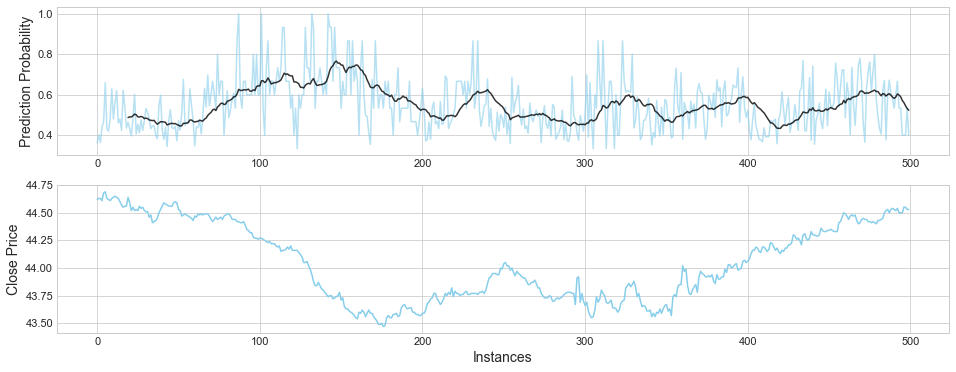

In [49]:
fig = plt.figure(figsize=[16,6])
fig.add_subplot(211)
max_prob = [np.amax(x) for x in prob1]
plt.plot(max_prob[:500], color = 'skyblue', alpha=0.6)
plt.ylabel('Prediction Probability', fontsize=14)
smoothed = ma.center_band(max_prob[:500], 20)
plt.plot(smoothed, color='k', alpha=0.8)
lag = len(df_test)-len(X_test) + w
ticker_close = df_test[ticker][lag:500+lag].values
fig.add_subplot(212)
plt.plot(ticker_close, color='skyblue')
plt.xlabel('Instances', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.savefig('../Figs/prob_trend.pdf', dpi=300)

In [50]:
len(max_prob)

1339

/Users/aravanshad/miniconda2/envs/py3k/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


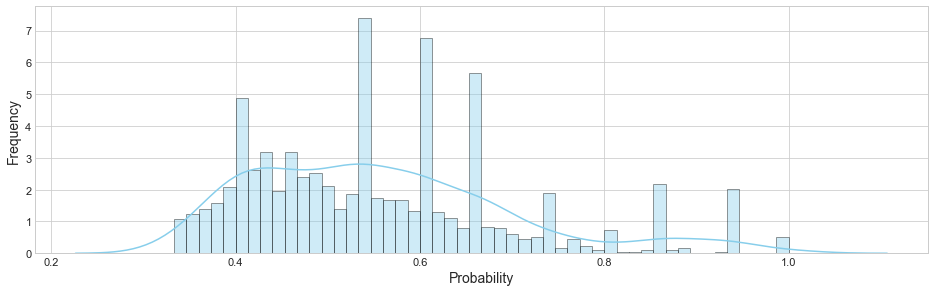

In [51]:
import seaborn as sns
fig2 = plt.figure(figsize=(16,10))
fig2.add_subplot(211)
sns.distplot(max_prob , bins=50, color='skyblue', hist_kws=dict(edgecolor="k", linewidth=1))
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.savefig('../Figs/prob_dist.pdf', dpi=300)

In [52]:
set(y_valid)-set(bm1), set(y_valid)-set(bm2)

(set(), set())

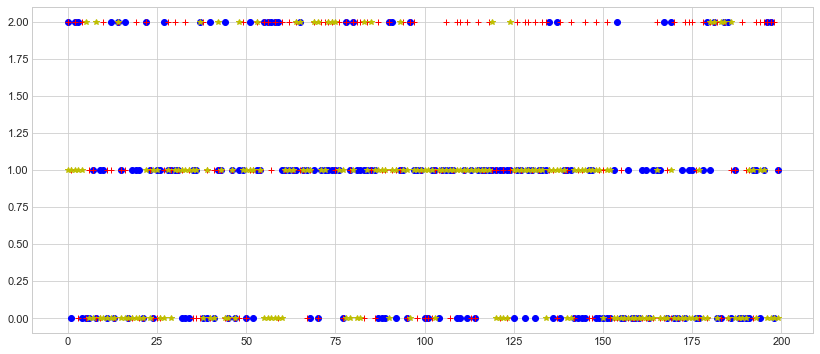

In [55]:
plt.figure(figsize=[14,6])
plt.plot(actual1[:200],'bo')
plt.plot(benchmark21[:200],'r+')
plt.plot(pred1[:200],'y*')